In [29]:
import pyreadr
from src.tde import time_delay_embedding
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# src:https://github.com/vcerqueira/blog
# pip install pyreadr

In [12]:
path = "rssa-master/rssa-master/data/AustralianWine.rda"
file = pyreadr.read_r(path)
print(file.keys())

odict_keys(['AustralianWine'])


In [16]:
wine=file["AustralianWine"]
#wine.set_index('date', inplace=True)
wine_ds = []
for col in wine:
   col_df = time_delay_embedding(wine[col], n_lags=12, horizon=6)
   wine_ds.append(col_df)

In [38]:
wine.to_csv("wine.csv",index=False)

将 time_delay_embedding 函数应用于时间序列中的每个变量（第 18-22 行）。

第 23 行将结果与数据集进行合并。

解释变量 (X) 是每个变量在每个时间步长的最后 12 个已知值（第 29 行）

目标变量在第30行中定义。这指的是未来销售的6个值:

In [17]:
wine_df = pd.concat(wine_ds, axis=1).dropna() 
predictor_variables = wine_df.columns.str.contains('\(t\-')
target_variables = wine_df.columns.str.contains('Sparkling\(t\+')
 
X = wine_df.iloc[:, predictor_variables]
Y = wine_df.iloc[:, target_variables]

In [18]:
#简单随机森林
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mse
from sklearn.ensemble import RandomForestRegressor

X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y, test_size=0.3, shuffle=False)
model = RandomForestRegressor()
model.fit(X_tr, Y_tr)
preds = model.predict(X_ts)
mse(Y_ts, preds)

294.6253819444445

上面的基线使用每个变量的 12 个滞后作为解释变量。这是在函数 time_delay_embedding 的参数 n_lags 中定义的。那么应该如何设置这个参数的值呢？

很难先验地说应该包括多少值，因为 这取决于输入数据和特定变量。

解决这个问题的一种简单方法是使用特征选择。从相当数量的值开始，然后根据重要性评分或预测性能来修改这个数字，或者直接使用GridSearch进行超参数的搜索。

我们这里将简单的演示一个判断的过程：根据随机森林的重要性得分选择前 10 个特征。

In [22]:
importance_scores = pd.Series(dict(zip(X_tr.columns, model.feature_importances_)))
top_10_features = importance_scores.sort_values(ascending=False)[:10]
top_10_features_nm = top_10_features.index
X_tr_top = X_tr[top_10_features_nm]
X_ts_top = X_ts[top_10_features_nm]

In [23]:
model_top_features = RandomForestRegressor()
model_top_features.fit(X_tr_top, Y_tr)
preds_topf = model_top_features.predict(X_ts_top)
mse(Y_ts, preds_topf)

262.89263888888894

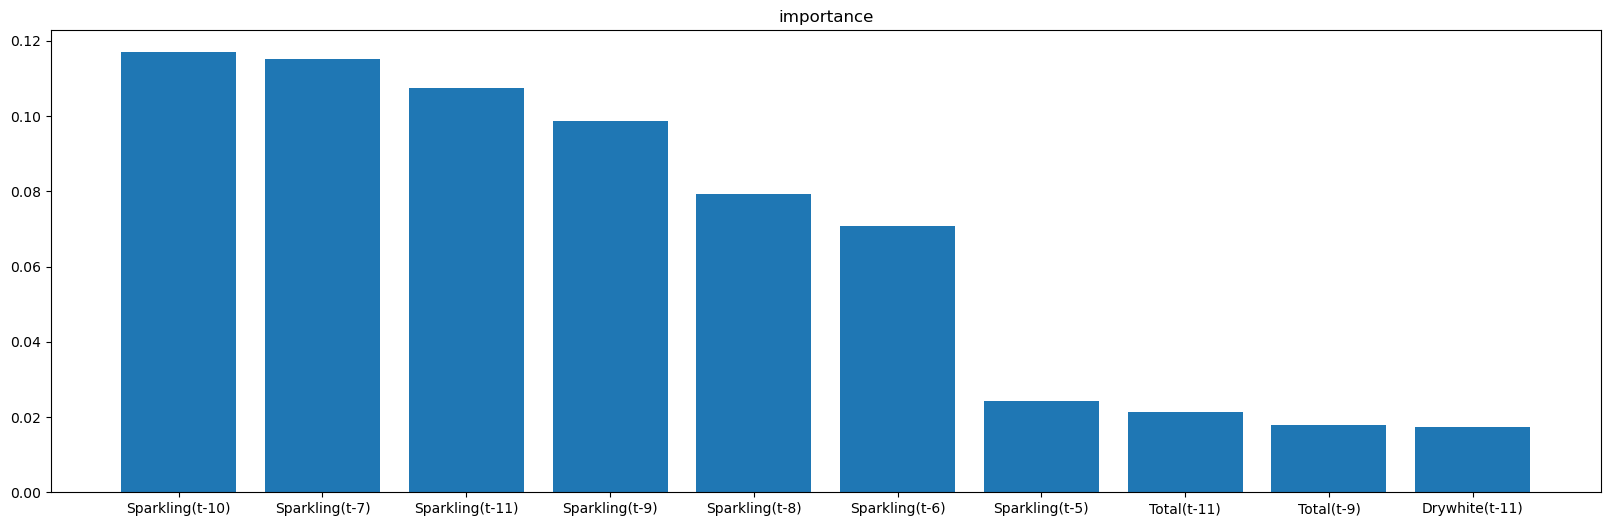

In [35]:
plt.figure(figsize=(20,6))
plt.bar(top_10_features.keys(),top_10_features.values)
plt.title("importance")
plt.show()

目标变量(Sparkling)的滞后是最重要的。但是其他变量的一些滞后也是相关的

多个目标变量预测，目前为止，我们都在预测单个变量（sparkling wine）。如果我们想要同时预测几个变量呢？

这种方法被称为：向量自回归 (VAR)